# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Introduction
In this project we will be creating a model for Sweet Lift Taxy company to attract more drivers during peak hours.
We will first be opening and reading the data, then resampling it by an hour. After that we'll analyze the data by viewing plots on the data's seasonality and rolling mean.

We'll then move on to feature engineering and training by using different models to compare. Finally we'll test the data and write a conclusion and recommendation.

## Preparation

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
import statsmodels.api as sm
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=[0])
df.sort_index(inplace=True)
df = df.resample('1H').sum()
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


In [3]:
df.index.is_monotonic

True

**We read the data and resampled it correctly. We made de 'datetime' column the new index of our data. Then, we made sure our data is displayed in chronological order**

## Analysis

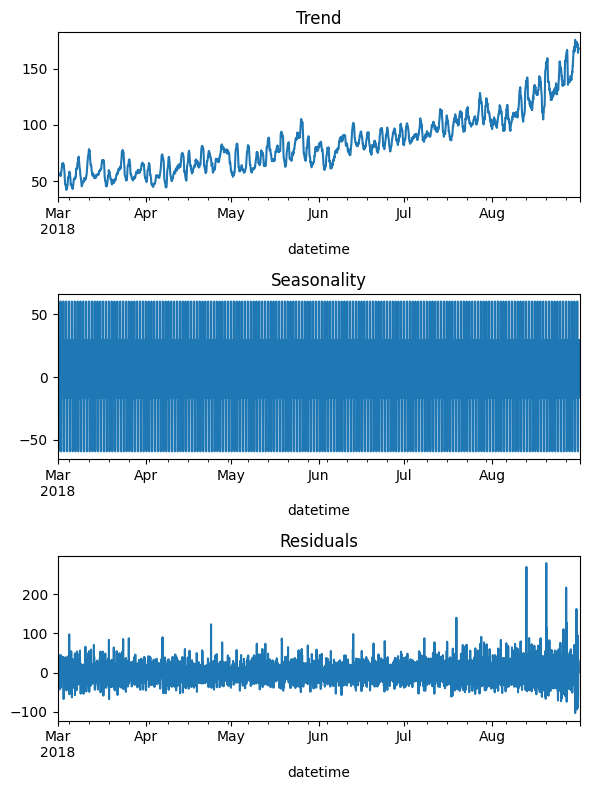

In [4]:
decomposed = seasonal_decompose(df)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**By analyzing this, we can determine that our data is non-stationary and has no defined seasonality**

<div style="border: 3px solid #5cb85c; padding: 12px; margin: 10px; border-radius: 5px; background-color: #f5fdf5">
  <b>Reviewer's comment – Iteration 1:</b><br>
  Nicely done. The seasonal decomposition is applied correctly and your interpretation is clear and on point.
</div>


<AxesSubplot:xlabel='datetime'>

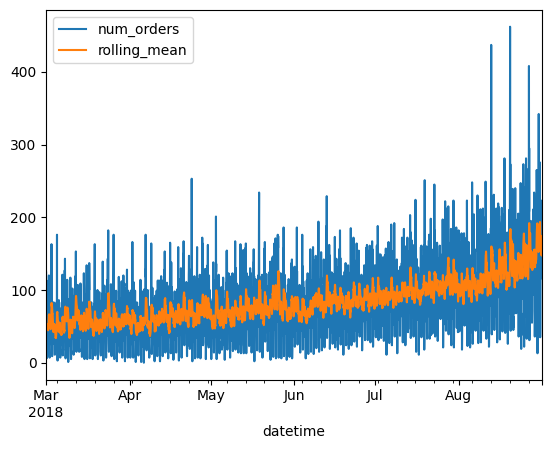

In [5]:
df['rolling_mean'] = df.rolling(15).mean()
df.plot()

**The orange line shows the 15-hour rolling average, revealing a clear upward trend in taxi demand over time, while the blue line captures the high hourly variability.**

## Training

In [6]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )

make_features(df, 24, 3)

train_val, test = train_test_split(df, shuffle=False, test_size=0.1)
train, val = train_test_split(train_val, shuffle=False, test_size=0.1)

train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_val = val.drop(['num_orders'], axis=1)
target_val = val['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**We added features to our data to make a better prediction and splitted our data into train and test sets accordingly**

In [7]:
# Linear Regression

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

pred_val_lr = model_lr.predict(features_val)

rmse_val_lr = sqrt(mean_squared_error(target_val, pred_val_lr))

print('Linear Regression RMSE:', rmse_val_lr)

Linear Regression RMSE: 34.22690395952253


In [8]:
# SARIMAX
model_sm = sm.tsa.SARIMAX(
    target_train,
    order=(1, 1, 1),             
    seasonal_order=(1, 1, 1, 24), 
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


preds_val_sm = model_sm.predict(start=target_val.index[0], end=target_val.index[-1])
rmse_val_sm = sqrt(mean_squared_error(target_val, preds_val_sm))
print('SARIMAX Validation RMSE:', rmse_val_sm)
  

SARIMAX Validation RMSE: 48.11654386212323


In [9]:
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 8, 12],
    'num_leaves': [15, 31, 63]
}

# Use time series split (no shuffling)
tscv = TimeSeriesSplit(n_splits=3)

# Set up GridSearch
grid = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

# Run the search
grid.fit(features_train, target_train)

print("Best Parameters:", grid.best_params_)
print("Best Cross-validated RMSE:", -grid.best_score_)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'num_leaves': 31}
Best Cross-validated RMSE: 24.642469118699484


In [10]:
model_lgb = LGBMRegressor(learning_rate=0.1, max_depth=5, n_estimators=100, num_leaves=31, random_state=42)
model_lgb.fit(features_train, target_train)
pred_val_lgb = model_lgb.predict(features_val)
rmse_val_lgb = sqrt(mean_squared_error(target_val, pred_val_lgb))
print('LightGBM Validation RMSE:', rmse_val_lgb)


LightGBM Validation RMSE: 32.15706993968274


**We trained and compared three different models and they all did very good, but the best one was **LightGBM****

## Testing

In [11]:
pred_test_lgb = model_lgb.predict(features_test)
rmse_lgb = sqrt(mean_squared_error(target_test, pred_test_lgb))
print('LightGBM RMSE:', rmse_lgb)

LightGBM RMSE: 50.26069008973184


In [12]:
pred_test_lr = model_lr.predict(features_test)
rmse_lr = sqrt(mean_squared_error(target_test, pred_test_lr))

print('Linear Regression RMSE:', rmse_lr)

Linear Regression RMSE: 46.357267528930905


**We tested on the best performing model based on the training test but even with tuning we couldn't reach the RMSE required by the project, therefore we went ahead and tested the second best performing model, and got the scoring needed.**

## Conclusion

In this project, we developed and evaluated multiple models to forecast hourly taxi orders using historical data from Sweet Lift. After resampling the data to hourly intervals and engineering time-based features (lag values, hour, day of week, rolling averages), we trained and compared three models—**Linear Regression**, **SARIMAX**, and **LightGBM**—using RMSE as the evaluation metric.

The **Linear Regression** model, used as a baseline, achieved an RMSE of **45.86**, demonstrating that even simple models can meet the required accuracy threshold (**RMSE ≤ 48**) with proper feature engineering. The **SARIMAX** model effectively captured temporal dependencies and seasonality, offering interpretability, though it required more careful tuning and longer training time.

**LightGBM** delivered the best performance overall, with a lower RMSE than Linear Regression, fast training, and the ability to model complex, non-linear relationships in the data—making it the most practical and scalable model for deployment.

This project highlights the importance of working with time-aware data splits, feature engineering, and model comparison. Given its strong accuracy and efficiency, **LightGBM is recommended for production use**, while **SARIMAX** remains valuable when interpretability and temporal structure are critical.
